In [5]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /Users/gerco/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Laboratorio 6 – Análisis de Redes Sociales (ARS)
- Diego Valenuzela - 22309
- Gerson Ramirez - 22281

## Ejercicio 1 y 2 – Descarga y carga de los archivos de datos

El archivo `traficogt.txt` ya está disponible en la carpeta `/data`.  
El archivo contiene **tweets en formato JSON**, uno por línea.  
En esta sección cargaremos el archivo en un DataFrame de `pandas`.

In [6]:
import json
import pandas as pd
from pathlib import Path

def load_jsonl(file_path):
    encodings_to_try = ["utf-8", "utf-8-sig", "utf-16", "latin1"]
    for enc in encodings_to_try:
        try:
            records = []
            with open(file_path, encoding=enc) as f:
                for line in f:
                    try:
                        records.append(json.loads(line))
                    except json.JSONDecodeError:
                        continue
            print(f"[OK] Leído {file_path} con encoding='{enc}' → {len(records)} registros")
            return pd.DataFrame(records)
        except UnicodeDecodeError:
            continue
    raise ValueError(f"No pude decodificar {file_path} con {encodings_to_try}")

# Cargar únicamente el archivo traficogt.txt
data_path = Path("data")
traficogt_df = load_jsonl(data_path / "traficogt.txt")

traficogt_df.head(2)

[OK] Leído data/traficogt.txt con encoding='utf-16' → 5604 registros


,id,id_str,url,date,user,lang,rawContent,replyCount,retweetCount,likeCount,...,coordinates,inReplyToTweetId,inReplyToTweetIdStr,inReplyToUser,source,sourceUrl,sourceLabel,media,card,_type
0,1834236045598056867,1834236045598056867,https://x.com/traficogt/status/183423604559805...,2024-09-12 14:22:06+00:00,"{'id': 93938886, 'id_str': '93938886', 'url': ...",es,Es comprensible la resolución... El ruso sabe ...,0,0,1,...,None,NaN,None,None,"<a href=""http://twitter.com/download/android"" ...",http://twitter.com/download/android,Twitter for Android,"{'photos': [], 'videos': [], 'animated': []}",None,snscrape.modules.twitter.Tweet
1,1834029142565658846,1834029142565658846,https://x.com/monymmorales/status/183402914256...,2024-09-12 00:39:56+00:00,"{'id': 976875408, 'id_str': '976875408', 'url'...",es,La corrupción de la @CC_Guatemala\nes descarad...,0,56,84,...,None,NaN,None,None,"<a href=""http://twitter.com/download/android"" ...",http://twitter.com/download/android,Twitter for Android,"{'photos': [], 'videos': [], 'animated': []}",{'title': 'La Corte de Constitucionalidad orde...,snscrape.modules.twitter.Tweet


## 3. Limpieza y preprocesamiento

Las tareas de limpieza aplicadas incluyen:

**Filtros básicos:**
- Normalización a minúsculas
- Eliminación de URLs, menciones (@usuario), hashtags
- Eliminación de números y combinaciones alfanuméricas
- Eliminación de signos de puntuación y caracteres especiales
- Eliminación de caracteres HTML y entidades

**Filtros avanzados:**
- **Stopwords expandidas**: Eliminación de stopwords en español + palabras comunes en redes sociales ('rt', 'via', 'cc', etc.)
- **Palabras poco informativas**: Eliminación de palabras muy comunes como 'q', 'si', 'va', 'dice', 'bien', 'mal', etc.
- **Filtros de longitud**: Eliminación de tokens menores a 3 caracteres y mayores a 20 caracteres
- **Caracteres repetidos**: Eliminación de tokens con 2 o menos caracteres únicos (ej: 'aaa', 'mmm')
- **Tweets vacíos**: Eliminación de tweets sin contenido después de la limpieza

**Extracción de metadatos:**
- ID de usuario, texto limpio, menciones, respuestas, retweets
- Eliminación de duplicados por ID de tweet

In [7]:
import re
import nltk
from nltk.corpus import stopwords

nltk.download("stopwords")
stopwords_es = set(stopwords.words("spanish"))

# Expandir stopwords con palabras comunes en redes sociales y palabras muy cortas/poco informativas
additional_stopwords = {
    'q', 'si', 'va', 'dice', 'asi', 'aqui', 'ahi', 'alla', 'ser', 'estar', 'hacer', 'dar', 'tener',
    'ir', 'ver', 'venir', 'decir', 'saber', 'poder', 'querer', 'poner', 'salir', 'pasar', 'llegar',
    'seguir', 'traer', 'parecer', 'quedar', 'creer', 'encontrar', 'sentir', 'buscar', 'acabar',
    'rt', 'via', 'cc', 'dm', 'ff', 'tl', 'tw', 'retweet', 'tweet', 'twitter', 'x', 'com', 'www',
    'http', 'https', 'amp', 'gt', 'lt', 'nbsp', 'br', 'div', 'span', 'img', 'href', 'src',
    'bien', 'mal', 'mejor', 'peor', 'mas', 'menos', 'mucho', 'poco', 'tanto', 'tan', 'muy',
    'solo', 'solamente', 'tambien', 'ademas', 'entonces', 'luego', 'despues', 'antes', 'ahora',
    'hoy', 'ayer', 'mañana', 'siempre', 'nunca', 'vez', 'veces', 'momento', 'tiempo', 'dia', 'dias',
    'año', 'años', 'mes', 'meses', 'hora', 'horas', 'minuto', 'minutos', 'segundo', 'segundos',
    'gt', 'lt', 'amp', 'nbsp', 'br', 'div', 'span', 'img', 'href', 'src', 'alt', 'title', 'class',
    'id', 'style', 'width', 'height', 'border', 'color', 'font', 'size', 'family', 'weight',
    'ah', 'oh', 'eh', 'mm', 'hmm', 'ok', 'okay', 'si', 'no', 'ja', 'jaja', 'jajaja', 'jeje', 'jiji',
    'aja', 'aha', 'uuu', 'aaa', 'ooo', 'eee', 'iii', 'wow', 'bah', 'meh', 'pfff', 'tsk', 'ups',
    'pues', 'bueno', 'entonces', 'claro', 'obviamente', 'realmente', 'verdaderamente', 'ciertamente'
}

all_stopwords = stopwords_es.union(additional_stopwords)

def clean_text(text: str) -> str:
    if pd.isna(text) or not text:
        return ""
    
    text = str(text).lower()
    
    # Eliminar URLs completas
    text = re.sub(r"https?://\S+", " ", text)
    text = re.sub(r"www\.\S+", " ", text)
    
    # Eliminar menciones y hashtags
    text = re.sub(r"@\w+", " ", text)
    text = re.sub(r"#\w+", " ", text)
    
    # Eliminar números y combinaciones alfanuméricas
    text = re.sub(r"\b\d+\b", " ", text)
    text = re.sub(r"\w*\d\w*", " ", text)
    
    # Eliminar signos de puntuación y caracteres especiales
    text = re.sub(r"[^\w\s]", " ", text)
    
    # Eliminar caracteres HTML y entidades
    text = re.sub(r"&\w+;", " ", text)
    text = re.sub(r"<[^>]+>", " ", text)
    
    # Eliminar espacios múltiples
    text = re.sub(r"\s+", " ", text)
    
    # Tokenizar y filtrar
    tokens = text.split()
    
    # Filtrar tokens
    filtered_tokens = []
    for token in tokens:
        # Eliminar tokens muy cortos (menos de 3 caracteres)
        if len(token) < 3:
            continue
        # Eliminar tokens muy largos (probablemente errores o URLs)
        if len(token) > 20:
            continue
        # Eliminar stopwords
        if token in all_stopwords:
            continue
        # Eliminar tokens que son solo caracteres repetidos
        if len(set(token)) <= 2 and len(token) > 2:
            continue
            
        filtered_tokens.append(token)
    
    return " ".join(filtered_tokens)

# Aplicar limpieza mejorada al dataset de traficogt
traficogt_df["text_clean"] = traficogt_df["rawContent"].apply(clean_text)
traficogt_df.drop_duplicates(subset=["id"], inplace=True)

# Filtrar tweets con texto limpio vacío
traficogt_df = traficogt_df[traficogt_df["text_clean"].str.len() > 0]

print(f"Tweets después de limpieza: {len(traficogt_df)}")
traficogt_df[["rawContent", "text_clean"]].head(3)

Tweets después de limpieza: 5149


[nltk_data] Downloading package stopwords to /Users/gerco/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,rawContent,text_clean
0,Es comprensible la resolución... El ruso sabe ...,comprensible resolución ruso sabe engrasar maq...
1,La corrupción de la @CC_Guatemala\nes descarad...,corrupción descarada falsificación documentos ...
4,@soy_502 @AztecaNoticiaGT @CONAPgt @DenunciaEM...,urgente zona deterioro tala inmoderada tráfico...


## 4. Análisis Exploratorio

Exploramos:
- Cantidad de tweets y usuarios únicos.
- Número de menciones, respuestas y retweets.
- Hashtags más frecuentes.
- Visualización con nube de palabras.

Esto permite generar preguntas de investigación iniciales.


=== traficogt ===
Tweets: 5149
Usuarios únicos: 1955
Menciones totales: 9695
Palabras únicas después de limpieza: 12386
Top 15 palabras más frecuentes:
  guatemala: 252
  corruptos: 203
  pueblo: 186
  presidente: 173
  así: 169
  gobierno: 147
  gente: 135
  país: 131
  puede: 125
  ley: 114
  van: 111
  debe: 111
  congreso: 110
  semilla: 109
  corrupción: 106


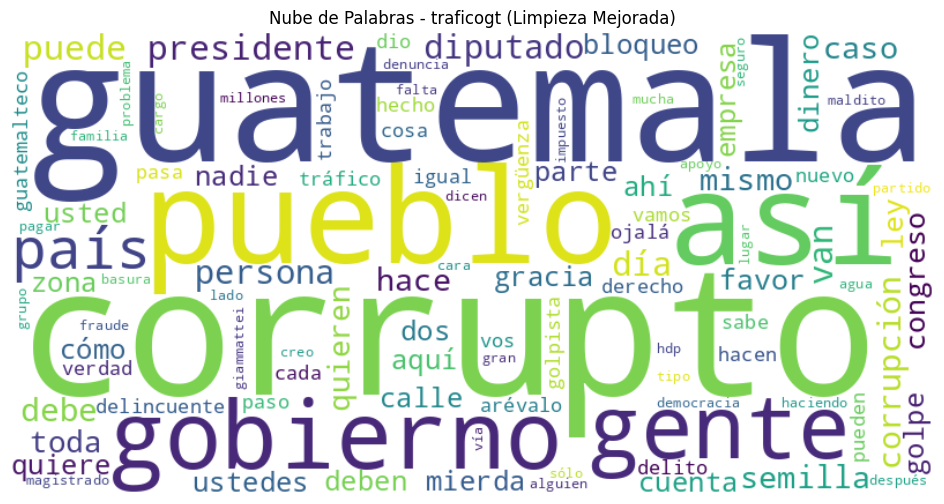

In [8]:
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def exploratory_stats(df, name):
    print(f"=== {name} ===")
    print("Tweets:", len(df))
    print("Usuarios únicos:", df["user"].apply(lambda x: x["username"]).nunique())
    
    mentions = sum(df["mentionedUsers"].dropna().apply(lambda x: len(x)))
    print("Menciones totales:", mentions)
    
    # Análisis de palabras más frecuentes
    all_words = " ".join(df["text_clean"]).split()
    word_freq = Counter(all_words)
    print(f"Palabras únicas después de limpieza: {len(word_freq)}")
    print("Top 15 palabras más frecuentes:")
    for word, count in word_freq.most_common(15):
        print(f"  {word}: {count}")

# Análisis exploratorio solo para traficogt
exploratory_stats(traficogt_df, "traficogt")

# Nube de palabras mejorada para traficogt
if len(traficogt_df) > 0 and traficogt_df["text_clean"].str.len().sum() > 0:
    wc = WordCloud(
        width=800, 
        height=400, 
        background_color="white",
        max_words=100,
        colormap='viridis'
    ).generate(" ".join(traficogt_df["text_clean"]))
    
    plt.figure(figsize=(12,6))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title("Nube de Palabras - traficogt (Limpieza Mejorada)")
    plt.show()
else:
    print("No hay suficiente texto limpio para generar la nube de palabras")

### Preguntas planteadas
1. ¿Qué usuarios son los más mencionados en el dataset de traficogt?
2. ¿Cuál es la densidad de interacciones en la red de traficogt?
3. ¿Qué temas emergen (hashtags más frecuentes) y cómo se relacionan con los usuarios más activos?

Estas preguntas guiarán el análisis de red en el siguiente paso.